# Attempt to copy what the paper does exactly

In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np

from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader

2025-08-13 10:02:26.519793: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 10:02:26.843661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755093746.961377    1568 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755093746.996149    1568 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755093747.253100    1568 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Raw data input
First change: edges are now the five SCF matrices.

In [2]:
data = np.load(r'/mnt/d/UROP/pyscf-tutorial/h2o_energies_noise_scf_matrices/h2o_noise_matrices_dft_b3lyp_def2-SVP_0.npz')
F, J, K, P, D, H, S = data['features']
print(H.shape, F.shape, P.shape, J.shape, K.shape)


(24, 24) (24, 24) (24, 24) (24, 24) (24, 24)


In [23]:
# define this! The rest can remain untouched
molecule = 'methanol'
n_atoms = 6



data_dir = Path(f'./{molecule}_energies_noise_scf_matrices')

In [24]:
C = [] # xyz coordinates
X = [] # calculated SCF matrix features
Y = [] # calculated energies

for file_path in data_dir.glob('*.npz'):
    data_file = np.load(file_path)
    try:
        C.append(data_file['coords'])
        X.append(data_file['features'])
        Y.append(data_file['energy'])

    except KeyError:
        raise KeyError('wrong key for npz file!')
# you must perform stacking, cannot just convert to array    
N, n_atoms, n_features, channels = np.stack(X).shape
X = np.stack(X)
C = np.stack(C)
Y = np.stack(Y)
print(X.shape)
print(Y.shape)

(1000, 7, 48, 48)
(1000,)


In [26]:
def hartree_to_kcal_per_mol(Y):
    return Y * 627.50961

Y = hartree_to_kcal_per_mol(Y)

In [100]:
x_train, x_valtest, y_train, y_valtest, c_train, c_valtest = train_test_split(X, Y, C, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test, c_val, c_test = train_test_split(x_valtest, y_valtest, c_valtest, test_size=0.33, random_state=42)

# 1) compute from TRAIN ONLY
y_mu = y_train.mean()
y_sd = y_train.std() + 1e-8
print("y_mu:", y_mu, "y_sd:", y_sd )

# 2) scale every split with the SAME mu/sd
y_train_s = (y_train - y_mu) / y_sd
y_val_s   = (y_val   - y_mu) / y_sd
y_test_s  = (y_test  - y_mu) / y_sd  # if you have test


print(x_train.shape, y_train.shape, c_train.shape)
print(x_val.shape, y_val.shape, c_val.shape)
print(x_test.shape, y_test.shape, c_test.shape)

y_mu: -45264298.38906596 y_sd: 703.9146138469423
(700, 7, 48, 48) (700,) (700, 6, 3)
(201, 7, 48, 48) (201,) (201, 6, 3)
(99, 7, 48, 48) (99,) (99, 6, 3)


Of course, we can define the edge features as well

In [138]:
from scipy import sparse

def edge_index_and_attr(F, J, K, P, H, D=None, S=None, tau=1e-4):
    N = F.shape[0]
    # fallbacks
    if D is None: D = np.zeros_like(F)
    if S is None: S = np.zeros_like(F)

    rows, cols, eattr = [], [], []
    for u in range(N):
        for v in range(N):
            if u == v:
                continue
            xuv = np.array([
                F[u, v], J[u, v], K[u, v], D[u, v], P[u, v], S[u, v], H[u, v]
            ], dtype='float32')

            # cutoff (pick ONE rule and keep it fixed across dataset)
            if np.max(np.abs(xuv)) >= tau:
                rows.append(u); cols.append(v); eattr.append(xuv)

    if len(rows) == 0:
        # Ensure graph is not empty (rare but possible with aggressive tau)
        return sparse.coo_matrix((np.zeros((0,), dtype='float32'), ([], [])), shape=(N, N)), \
               np.zeros((0, 7), dtype='float32')

    # strongly connected graph
    A = sparse.csr_matrix((np.ones(len(rows), dtype='float32'), (rows, cols)), shape=(N, N))

    # edges: non-diagonal elements of the five SCF matrices
    E = np.stack(eattr, axis=0)  # (E, 7)
    return A, E


class SCFAtomGraphDataset(Dataset):
    def __init__(self, X, Y, tau=1e-4, **kwargs):
        """
        Dataset for SCF atom graphs.
        """
        self.X = X.astype('float32')         # (N, 5, 24, 24)
        self.Y = Y.astype('float32')         # (N,)
        self.tau = tau
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for x, y in zip(self.X, self.Y):
            H, F, P, J, K, D, S = x
            # node features: take diagonal component of all five SCF matrix
            x = np.stack([np.diag(m) for m in (F, J ,K, P, H)], axis=-1)  # (5, 24, 24)
            a, e = edge_index_and_attr(F, J, K, P, H, D, S, tau=self.tau)

            graphs.append(Graph(x=x, a=a, y=y, e=e))
        return graphs

### Setting up datasets and loaders

In [139]:
epochs = 1000
batch_size = 32

train_dataset = SCFAtomGraphDataset(X=x_train, Y=y_train_s, tau=1e-4)
val_dataset = SCFAtomGraphDataset(X=x_val, Y=y_val_s, tau=1e-4)
test_dataset = SCFAtomGraphDataset(X=x_test, Y=y_test_s, tau=1e-4)

train_loader = DisjointLoader(train_dataset, batch_size=batch_size, epochs=epochs, shuffle=True)
val_loader = DisjointLoader(val_dataset, batch_size=batch_size, epochs=epochs, shuffle=False)
test_loader = DisjointLoader(test_dataset, batch_size=batch_size, epochs=epochs, shuffle=False) 

## Model Compilation
Customize message passing, instead of just GraphSageConv.

### Model 1: Ordinary GNN Model

In [146]:
from spektral.layers import GraphSageConv, GlobalSumPool
'''
tried: GCNConv (only accepts [x,a], cannot accept disjoint batches
GCSConv (shape mismatch)
GINConv (tf error)
GraphSageConv + disable XLA flag + operate on CPU (forced). Both must be present for it work somehow.
'''
@keras.saving.register_keras_serializable(package="custom")
class GNNModel(tf.keras.Model):
    def __init__(self, name=None):
        super().__init__(name=name)
        he_init = tf.keras.initializers.HeNormal()

        # ReLU and GeLU layers are best with HeNormal. Default is GlorotUniform, which isn't the most ideal; does not affect performance
        self.conv1 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros') 
        self.conv2 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros')
        self.pool = GlobalSumPool()
        self.dense = tf.keras.layers.Dense(1, 
                                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05),
                                           bias_initializer='zeros')

    def call(self, inputs):
        # supports both with/without edge features
        if len(inputs) == 4:
            x, a, e, i = inputs
            x = self.conv1([x, a, e])
            x = self.conv2([x, a, e])
        else:
            x, a, i = inputs
            x = self.conv1([x, a])
            x = self.conv2([x, a])

        out = self.pool([x, i])
        return self.dense(out)


In [152]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def train_GNN(train_loader, val_loader,
              epochs=10, batch_size=32, threshold=2.5, verbose=0):

    model = GNNModel()
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1000, min_lr=1e-6)
    # model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=1300, restore_best_weights=True)

    # Train
    history = model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch,
                        validation_data=val_loader.load(), validation_steps=val_loader.steps_per_epoch,
                        epochs=epochs, verbose=verbose,callbacks=[lr_scheduler, early_stop])    
    
    return model, history.history

In [153]:
gnn_model, history = train_GNN(train_loader=train_loader, val_loader=val_loader,
                           epochs=5000, verbose=1, threshold=2.0)

Epoch 1/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2280

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'SCFAtomGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.1025 - val_loss: 0.7611 - learning_rate: 0.0010
Epoch 2/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0320 - val_loss: 0.7688 - learning_rate: 0.0010
Epoch 3/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ -1s 24ms/step - loss: 1.0206 - val_loss: 0.8438 - learning_rate: 0.0010
Epoch 4/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0163 - val_loss: 0.7914 - learning_rate: 0.0010
Epoch 5/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9932 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 6/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9978 - val_loss: 0.7496 - learning_rate: 0.0010
Epoch 7/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0155 - val_loss: 0.7490 - learning_rate: 0.0010
Epoch 8/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0223 - val_loss: 0.7511 - learning_rate: 0.0010
Epoch 9/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0108 - val_loss: 0.7511 - learning_rate: 0.0010
Epoch 10/5000

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9672 - learning_rate: 0.0010
Epoch 735/5000
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0424

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9915 - learning_rate: 0.0010
Epoch 736/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0166 - learning_rate: 0.0010
Epoch 737/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9861 - learning_rate: 0.0010
Epoch 738/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0328 - learning_rate: 0.0010
Epoch 739/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0148 - learning_rate: 0.0010
Epoch 740/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9545 - learning_rate: 0.0010
Epoch 741/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0134 - learning_rate: 0.0010
Epoch 742/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0018 - learning_rate: 0.0010
Epoch 743/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9966 - learning_rate: 0.0010
Epoch 744/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0116 - learning_rate: 0.0010
Epoch 745/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9838 - lea

2025-08-14 13:49:51.075511: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9651 - learning_rate: 0.0010
Epoch 800/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0179 - learning_rate: 0.0010
Epoch 801/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9861 - learning_rate: 0.0010
Epoch 802/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ -1s -55733us/step - loss: 1.0048 - learning_rate: 0.0010
Epoch 803/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0386 - learning_rate: 0.0010
Epoch 804/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9498 - learning_rate: 0.0010
Epoch 805/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0196 - learning_rate: 0.0010
Epoch 806/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0020 - learning_rate: 0.0010
Epoch 807/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9894 - learning_rate: 0.0010
Epoch 808/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0151 - learning_rate: 0.0010
Epoch 809/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9844 

2025-08-14 13:54:08.274241: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4962/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4963/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4964/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4965/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4966/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4967/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4968/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4969/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4970/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4971/5000
22/22 ━━━━━━━━━━━━━━

### Model 2: OrbNet (from ChatGPT)

In [93]:
# =========================
# OrbNet-style GNN (minimal, no Dataset code)
# Nodes: 5 features (e.g., [F,J,K,P,H]); Edges: 7 ([F,J,K,D,P,S,H])
# =========================
import math, numpy as np, tensorflow as tf

# -------- Cutoff helpers (from raw operator tensors: x_train shaped (N, 7, n, n) or (N, n, n, 7)) --------
def ensure_channels_first(X, expected_channels=7):
    X = np.asarray(X); assert X.ndim == 4, f"Expected 4D, got {X.shape}"
    N, a1, a2, a3 = X.shape
    if expected_channels in (a1, a2, a3):
        c_ax = [a1, a2, a3].index(expected_channels) + 1
    else:
        if a1 == a2: c_ax = 3
        elif a1 == a3: c_ax = 2
        elif a2 == a3: c_ax = 1
        else: c_ax = int(np.argmin([a1, a2, a3])) + 1
    mat_axes = [ax for ax in (1,2,3) if ax != c_ax]
    assert X.shape[mat_axes[0]] == X.shape[mat_axes[1]], "Matrix axes must be square"
    return np.transpose(X, axes=[0, c_ax, mat_axes[0], mat_axes[1]])  # (N, C, n, n)

def compute_cutoffs_any(X, pct=99.5, nonzero_only=True, expected_channels=7):
    Xcf = ensure_channels_first(X, expected_channels)   # (N, C, n, n)
    N, C, n, _ = Xcf.shape
    offmask_flat = (~np.eye(n, dtype=bool)).reshape(-1)
    c_nodes = np.empty(C, dtype='f4'); c_edges = np.empty(C, dtype='f4')
    for c in range(C):
        M = Xcf[:, c, :, :]                                   # (N, n, n)
        di = np.abs(np.diagonal(M, axis1=1, axis2=2)).ravel()
        if nonzero_only: di = di[di != 0]
        c_nodes[c] = np.percentile(di, pct) if di.size else 1.0
        flat = M.reshape(N, -1)
        off = np.abs(flat[:, offmask_flat]).ravel()
        if nonzero_only: off = off[off != 0]
        c_edges[c] = np.percentile(off, pct) if off.size else c_nodes[c]
    return np.maximum(c_nodes, 1e-6), np.maximum(c_edges, 1e-6)

# -------------------- Core layers --------------------
def he_trunc():
    return tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal')

class NormAct(tf.keras.layers.Layer):
    def __init__(self): super().__init__(); self.ln=tf.keras.layers.LayerNormalization(epsilon=1e-5)
    def call(self,x): return tf.keras.activations.gelu(self.ln(x))

class NodeSineRBF(tf.keras.layers.Layer):
    """ φ_n^h(r)=sin(π n r), n=1..nr; input (N, d_node), output (N, d_node*nr) """
    def __init__(self, nr, c_nodes):
        super().__init__()
        self.nr = int(nr)
        self.c_nodes = tf.constant(c_nodes, tf.float32)
        self.d_node = int(self.c_nodes.shape[0])
    def call(self, x):
        x = x / self.c_nodes
        n = tf.range(1, self.nr + 1, dtype=tf.float32)[None, None, :]
        bases = tf.sin(tf.constant(math.pi, tf.float32) * n * x[:, :, None])   # (N, d_node, nr)
        out = tf.reshape(bases, [-1, self.d_node * self.nr])
        out.set_shape([None, self.d_node * self.nr])
        return out

class EdgeBesselRBF(tf.keras.layers.Layer):
    """ φ_m^e(r)=√2/c * sin(π m r/c)/(r/c) * I(r), m=1..mr; input (E, e_dim) -> (E, e_dim*mr) """
    def __init__(self, mr, c_edges, eps=1e-8):
        super().__init__()
        self.mr = int(mr)
        self.c = tf.constant(c_edges, tf.float32)  # (e_dim,)
        self.e_dim = int(self.c.shape[0])
        self.eps = eps
    def call(self, e):
        c = self.c[None, :]                       # (1, e_dim)
        r = e                                     # (E, e_dim)
        abs_r = tf.abs(r)
        in_cut = tf.cast(abs_r < c, tf.float32)
        I = tf.exp(-(c**2) * ((abs_r - c)**2 + 1.0)) * in_cut
        m = tf.range(1, self.mr + 1, dtype=tf.float32)[None, None, :]
        z = tf.constant(math.pi, tf.float32) * m * (r[:, :, None] / c[:, :, None])
        sinz_over_z = tf.where(tf.abs(z) > self.eps, tf.sin(z) / z, tf.ones_like(z))
        phi = (tf.sqrt(2.0) / c[:, :, None]) * sinz_over_z * I[:, :, None]
        out = tf.reshape(phi, [-1, self.e_dim * self.mr])
        out.set_shape([None, self.e_dim * self.mr])
        return out

class ResidualMLP3(tf.keras.layers.Layer):
    def __init__(self, width, p=0.0):
        super().__init__()
        self.d1=tf.keras.layers.Dense(width,kernel_initializer=he_trunc(),bias_initializer='zeros')
        self.d2=tf.keras.layers.Dense(width,kernel_initializer=he_trunc(),bias_initializer='zeros')
        self.d3=tf.keras.layers.Dense(width,kernel_initializer=he_trunc(),bias_initializer='zeros')
        self.na=NormAct(); self.drop=tf.keras.layers.Dropout(p)
    def call(self,x,training=False):
        y1=tf.keras.activations.gelu(self.d1(x))
        y2=tf.keras.activations.gelu(self.d2(self.drop(y1,training=training)))
        y3=self.d3(self.drop(y2,training=training))
        return self.na(y3 + y1)

class OrbNetMPL(tf.keras.layers.Layer):
    """ One message-passing layer per Eqs. (16)-(19) with multi-head sigmoid attention. """
    def __init__(self, d_h, n_e, heads=4, msg_dim=None, p=0.0):
        super().__init__()
        self.d_h, self.n_e, self.H = d_h, n_e, heads
        self.msg = msg_dim or d_h
        self.drop = tf.keras.layers.Dropout(p)
        self.Wm1 = tf.keras.layers.Dense(n_e, kernel_initializer=he_trunc(), bias_initializer='zeros')
        self.Wm2 = tf.keras.layers.Dense(self.msg, kernel_initializer=he_trunc(), bias_initializer='zeros')
        self.Wa  = [tf.keras.layers.Dense(n_e, kernel_initializer=he_trunc(), bias_initializer='zeros') for _ in range(self.H)]
        self.Wh  = tf.keras.layers.Dense(d_h, kernel_initializer=he_trunc(), bias_initializer='zeros')
        self.We  = tf.keras.layers.Dense(n_e, kernel_initializer=he_trunc(), bias_initializer='zeros')
        self.naH, self.naE = NormAct(), NormAct()
        self.sigA = tf.keras.activations.sigmoid
        self._eaux_cache = None  # set by parent model each forward
    def call(self, inputs, training=False):
        x, a, e, i = inputs                         # a: tf.SparseTensor
        idx = tf.cast(a.indices, tf.int32); u, v = idx[:,0], idx[:,1]
        hu = tf.gather(x, u); hv = tf.gather(x, v)
        triple = self.Wm1(hu) * self.Wm1(hv) * e
        m = self.drop(self.Wm2(triple), training=training)          # (E, msg)
        N = tf.shape(x)[0]; eaux = self._eaux_cache if self._eaux_cache is not None else e
        agg = []
        for Wa in self.Wa:
            au, av = Wa(hu), Wa(hv)
            s = tf.reduce_mean(au * av * e * eaux, axis=-1, keepdims=True)  # (E,1)
            w = self.sigA(s); mw = w * m
            agg.append(tf.math.unsorted_segment_sum(mw, u, N))             # (N, msg)
        Hcat = tf.concat(agg, axis=-1)                                      # (N, H*msg)
        x = x + self.naH(self.Wh(Hcat))
        e = self.naE(self.We(m))
        return x, a, e, i

# -------------------- Full model --------------------
import keras
import tensorflow as tf

@keras.saving.register_keras_serializable(package="notebook", name="OrbNetModel")
class OrbNetModel(tf.keras.Model):
    """
    Inputs (from your DisjointLoader): (x_nodes, a_sparse, e_edges, i_segment)
      x_nodes: (N_nodes_in_batch,  d_node)   [d_node=5]
      e_edges: (E_edges_in_batch,  e_dim)    [e_dim=7]
    """
    def __init__(self, d_h=128, n_e=64, heads=4, L=3, nr=8, mr=8,
                 c_nodes=None, c_edges=None, dropout=0.1, y_bias=0.0,
                 **kwargs):                                # <-- accept Keras kwargs
        super().__init__(**kwargs)                         # <-- forward them

        # save hyperparams for get_config()
        self.d_h = d_h
        self.n_e = n_e
        self.heads = heads
        self.L = L
        self.nr = nr
        self.mr = mr
        self.c_nodes = c_nodes
        self.c_edges = c_edges
        self.dropout = dropout
        self.y_bias_init = float(y_bias)

        # embeddings (custom layers must be serializable/registered, see note below)
        self.node_rbf = NodeSineRBF(nr, c_nodes)
        self.edge_rbf = EdgeBesselRBF(mr, c_edges)
        self.Ench = ResidualMLP3(d_h, dropout)
        self.Ence = ResidualMLP3(n_e, dropout)
        self.Aux  = tf.keras.layers.Dense(n_e, use_bias=False, kernel_initializer=he_trunc())

        # MPL stack
        self.mpls = [OrbNetMPL(d_h, n_e, heads, msg_dim=d_h, p=dropout) for _ in range(L)]

        # per-layer decoders
        self.Dec  = [tf.keras.Sequential([
                        tf.keras.layers.Dense(d_h, activation='gelu', kernel_initializer=he_trunc(), bias_initializer='zeros'),
                        tf.keras.layers.Dense(1, kernel_initializer=he_trunc(), bias_initializer='zeros'),
                    ]) for _ in range(L+1)]

        # trainable bias
        self.yb = tf.Variable(self.y_bias_init, trainable=True, dtype=tf.float32, name="y_bias")

    def call(self, inputs, training=False):
        x_raw, a, e_raw, i = inputs
        # embeddings
        h0 = self.Ench(self.node_rbf(x_raw), training=training)  # (N, d_h)
        erbf = self.edge_rbf(e_raw)                              # (E, 7*mr)
        e0 = self.Ence(erbf, training=training)                  # (E, n_e)
        eaux = self.Aux(erbf)                                    # (E, n_e)
        for layer in self.mpls:
            layer._eaux_cache = eaux

        # decode l=0 (size-extensive via segment_sum)
        y = tf.math.segment_sum(tf.squeeze(self.Dec[0](h0), -1), tf.cast(i, tf.int32))

        # MPLs + decode per layer
        h, e = h0, e0
        for l, mpl in enumerate(self.mpls, start=1):
            h, a, e, i = mpl([h, a, e, i], training=training)
            y += tf.math.segment_sum(tf.squeeze(self.Dec[l](h), -1), tf.cast(i, tf.int32))
        return y + self.yb

    # ---- Serialization hooks ----
    def get_config(self):
        base = super().get_config()
        base.update({
            "d_h": self.d_h, "n_e": self.n_e, "heads": self.heads, "L": self.L,
            "nr": self.nr, "mr": self.mr, "c_nodes": self.c_nodes, "c_edges": self.c_edges,
            "dropout": self.dropout, "y_bias": float(self.y_bias_init),
        })
        return base

    @classmethod
    def from_config(cls, config):
        # Keras may pass trainable/dtype/name in `base`; they’re handled by super().__init__(**kwargs)
        return cls(**config)

## Training

In [ ]:
# compute cutoff
c_nodes_full, c_edges = compute_cutoffs_any(x_train, pct=99.5, expected_channels=7)
c_nodes = c_nodes_full[[0, 1, 2, 4, 6]]   # len = 5

# 2) Model + compile (assumes y_train_s exists; otherwise set y_bias=0.0)
tf.config.optimizer.set_jit(False)  # avoid sparse/XLA quirks
y_bias = float(np.mean(y_train_s)) if 'y_train_s' in locals() else 0.0

model = OrbNetModel(
    d_h=128, n_e=64, heads=4, L=3, nr=8, mr=8,
    c_nodes=c_nodes, c_edges=c_edges,
    dropout=0.10, y_bias=y_bias
)

opt = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4, global_clipnorm=1.0)
model.compile(optimizer=opt, loss='mse')

# 3) Train (your loaders must already exist)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=80, min_lr=1e-6, verbose=1),
]
history = model.fit(
    train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch,
    validation_data=val_loader.load(), validation_steps=val_loader.steps_per_epoch,
    epochs=5000, callbacks=callbacks, verbose=1
)



Epoch 1/5000


/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['orb_net_model_1/orb_net_mpl_5/dense_69/kernel', 'orb_net_model_1/orb_net_mpl_5/dense_69/bias', 'orb_net_model_1/orb_net_mpl_5/norm_act_15/layer_normalization_15/gamma', 'orb_net_model_1/orb_net_mpl_5/norm_act_15/layer_normalization_15/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'SCFAtomGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 6175.2285 - val_loss: 370.4222 - learning_rate: 3.0000e-04
Epoch 2/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 977ms/step - loss: 706.3958 - val_loss: 956.3312 - learning_rate: 3.0000e-04
Epoch 3/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 515.6021 - val_loss: 99.6206 - learning_rate: 3.0000e-04
Epoch 4/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 392.2156 - val_loss: 412.2973 - learning_rate: 3.0000e-04
Epoch 5/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 970ms/step - loss: 94.5350 - val_loss: 107.1236 - learning_rate: 3.0000e-04
Epoch 6/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 56.0759 - val_loss: 36.2266 - learning_rate: 3.0000e-04
Epoch 7/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 45.6463 - val_loss: 108.1883 - learning_rate: 3.0000e-04
Epoch 8/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 965ms/step - loss: 53.2860 - val_loss: 5.5902 - learning_rate: 3.0000e-04
Epoch 9/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 51.8250

2025-08-13 22:07:29.650493: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on me

22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 883ms/step - loss: 0.1157 - learning_rate: 7.5000e-05
Epoch 878/5000


2025-08-13 22:07:49.107332: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 957ms/step - loss: 0.1169 - learning_rate: 7.5000e-05
Epoch 879/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 883ms/step - loss: 0.1116 - learning_rate: 7.5000e-05
Epoch 880/5000


2025-08-13 22:08:29.535261: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 956ms/step - loss: 0.0936 - learning_rate: 7.5000e-05
Epoch 881/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 953ms/step - loss: 0.0988 - learning_rate: 7.5000e-05
Epoch 882/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 880ms/step - loss: 0.0934 - learning_rate: 7.5000e-05
Epoch 883/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 957ms/step - loss: 0.0524 - learning_rate: 7.5000e-05
Epoch 884/5000


2025-08-13 22:09:51.741787: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 878ms/step - loss: 0.0417 - learning_rate: 7.5000e-05
Epoch 885/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 958ms/step - loss: 0.0408 - learning_rate: 7.5000e-05
Epoch 886/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 957ms/step - loss: 0.0376 - learning_rate: 7.5000e-05
Epoch 887/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 875ms/step - loss: 0.0373 - learning_rate: 7.5000e-05
Epoch 888/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 958ms/step - loss: 0.0395 - learning_rate: 7.5000e-05
Epoch 889/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0365 - learning_rate: 7.5000e-05
Epoch 890/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 965ms/step - loss: 0.0346 - learning_rate: 7.5000e-05
Epoch 891/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 887ms/step - loss: 0.0373 - learning_rate: 7.5000e-05
Epoch 892/5000


2025-08-13 22:12:55.332849: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 966ms/step - loss: 0.0319 - learning_rate: 7.5000e-05
Epoch 893/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 888ms/step - loss: 0.0343 - learning_rate: 7.5000e-05
Epoch 894/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 968ms/step - loss: 0.0340 - learning_rate: 7.5000e-05
Epoch 895/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 972ms/step - loss: 0.0392 - learning_rate: 7.5000e-05
Epoch 896/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 889ms/step - loss: 0.0423 - learning_rate: 7.5000e-05
Epoch 897/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 966ms/step - loss: 0.0357 - learning_rate: 7.5000e-05
Epoch 898/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.0364 - learning_rate: 7.5000e-05
Epoch 899/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 879ms/step - loss: 0.0343 - learning_rate: 7.5000e-05
Epoch 900/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 966ms/step - loss: 0.0351 - learning_rate: 7.5000e-05
Epoch 901/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 962ms/step - loss: 0.0346 - learning_rate: 7.5000e-05
Epoch 902/5000
22/

2025-08-13 22:19:06.051188: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 981ms/step - loss: 0.0385 - learning_rate: 7.5000e-05
Epoch 909/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 872ms/step - loss: 0.0377 - learning_rate: 7.5000e-05
Epoch 910/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 933ms/step - loss: 0.0345 - learning_rate: 7.5000e-05
Epoch 911/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 973ms/step - loss: 0.0322 - learning_rate: 7.5000e-05
Epoch 912/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 874ms/step - loss: 0.0340 - learning_rate: 7.5000e-05
Epoch 913/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 966ms/step - loss: 0.0353 - learning_rate: 7.5000e-05
Epoch 914/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 870ms/step - loss: 0.0404 - learning_rate: 7.5000e-05
Epoch 915/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 959ms/step - loss: 0.0349 - learning_rate: 7.5000e-05
Epoch 916/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 960ms/step - loss: 0.0364 - learning_rate: 7.5000e-05
Epoch 917/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 881ms/step - loss: 0.0349 - learning_rate: 7.5000e-05
Epoch 918/5000


2025-08-13 22:30:42.151166: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 880ms/step - loss: 0.1444 - learning_rate: 7.5000e-05
Epoch 941/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 960ms/step - loss: 0.0459 - learning_rate: 7.5000e-05
Epoch 942/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 874ms/step - loss: 0.0409 - learning_rate: 7.5000e-05
Epoch 943/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0519 - learning_rate: 7.5000e-05
Epoch 944/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 876ms/step - loss: 0.1092 - learning_rate: 7.5000e-05
Epoch 945/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 960ms/step - loss: 0.1023 - learning_rate: 7.5000e-05
Epoch 946/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 878ms/step - loss: 0.1210 - learning_rate: 7.5000e-05
Epoch 947/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 962ms/step - loss: 0.1332 - learning_rate: 7.5000e-05
Epoch 948/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 963ms/step - loss: 0.1143 - learning_rate: 7.5000e-05
Epoch 949/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 881ms/step - loss: 0.2292 - learning_rate: 7.5000e-05
Epoch 950/5000
22/

2025-08-13 22:51:51.413994: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1006/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1007/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1008/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1009/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1010/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1011/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1012/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1013/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1014/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e

2025-08-13 22:51:54.651890: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1071/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1072/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1073/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1074/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1075/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1076/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1077/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1078/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1079/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e

2025-08-13 22:52:01.005503: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1199/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1200/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1201/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1202/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1203/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1204/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1205/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1206/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1207/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e

2025-08-13 22:52:15.403583: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1455/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1456/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1457/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1458/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1459/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1460/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1461/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1462/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1463/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e

2025-08-13 22:52:41.111758: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1967/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1968/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1969/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1970/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1971/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1972/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1973/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1974/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 1975/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e

2025-08-13 22:53:31.587369: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2991/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2992/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2993/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2994/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2995/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2996/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2997/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2998/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e-05
Epoch 2999/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - learning_rate: 7.5000e

TypeError: unsupported format string passed to list.__format__

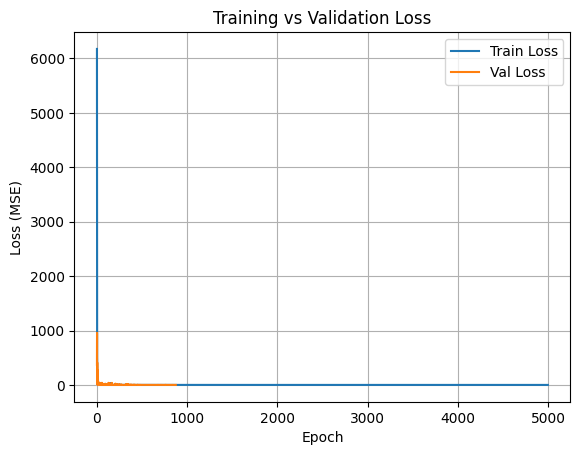

In [32]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [103]:
print(x_test.shape, y_test_s.shape)

(99, 7, 48, 48) (99,)


In [104]:
# Evaluate on test set
test_loss = model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
print(f"Test MSE loss: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0107
Test MSE loss: 0.01


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
y_pred shape: (99,)


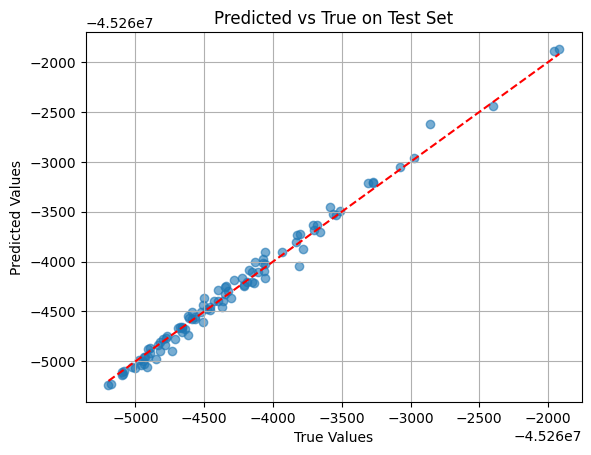

In [105]:
# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()
y_pred   = (y_pred * y_sd) + y_mu

# 3) Now y_pred.shape == y_true.shape == 99
print("y_pred shape:", y_pred.shape)

# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()


In [125]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MAE: 9.139520e+02
R²:  -1.6578


### Save / load model

In [107]:
model_dir = Path('./gnn_model/')
model_dir.mkdir(parents=True, exist_ok=True)

model.save(model_dir / 'met_gnn_model_orbnet_5_577e1.keras')

In [97]:
model = keras.models.load_model(
    str(model_dir / 'met_gnn_model_orbnet_5_577e1.keras'),
    custom_objects={"OrbNetModel": OrbNetModel},  # safe even with @register
    compile=False,
    safe_mode=False
)


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

## Test on translational invariance

In [119]:
# Evaluation on: CNN, GNN. We have x_test, y_test
from numpy.random import default_rng

def translation(X, offset=10.0):
    '''
    Offset: a (3,) vector (tuple) or a scaler. 
    '''
    off = np.asarray(offset)
    if off.ndim == 0:
        off = np.array([off, off, off])
    return X + off  # broadcasting: (N,n_atoms,3) + (3,) → (N,n_atoms,3)

def rotate_180_y_axis(X):
    R = np.array([[-1, 0, 0],
              [ 0, 1, 0],
              [ 0, 0,-1]])
    return X @ R.T

def permutation(X, seed=None):
    N, n_atoms, xyz = X.shape
    rng = default_rng(seed)          # create a Generator with seed 42
    perm = rng.permutation(n_atoms)
    return X[:, perm, :]

Step 1: save test dataset's energies and xyz coordinates

In [74]:
x_test.shape, y_test.shape, c_test.shape

((99, 7, 24, 24), (99,), (99, 6, 3))

In [75]:
np.save(f'./test_xyz_{molecule}.npy', c_test)

In [120]:
x_test_t = np.load('./features/test_matrices_h2o_permutated.npy')
y_test_s = y_test_s
# c_test =np.load('./test_xyz_h2o_permutated.npy')permutated

In [121]:
print(x_test.shape, y_test.shape, c_test.shape)

(99, 7, 48, 48) (99,) (99, 6, 3)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
y_pred shape: (99,)


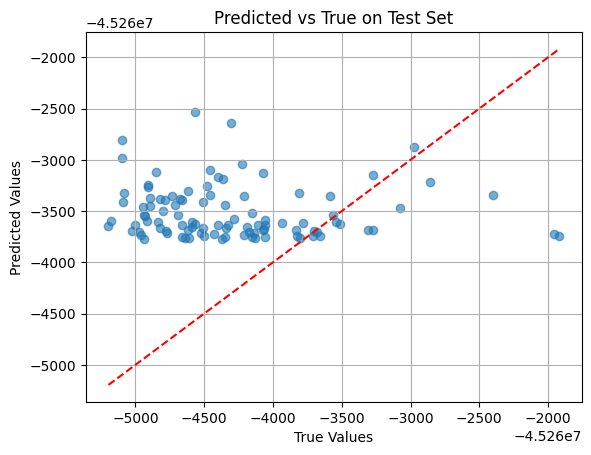

In [123]:
# CRITICAL: **Re‐instantiate** the loader for prediction
test_dataset_2 = SCFAtomGraphDataset(X=x_test_t, Y=y_test_s, tau=1e-4)
pred_loader = DisjointLoader(test_dataset_2, batch_size=32, epochs=1, shuffle=False)
y_pred = model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()
y_pred   = (y_pred * y_sd) + y_mu

# 3) Now y_pred.shape == y_true.shape == 99
print("y_pred shape:", y_pred.shape)

# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MAE: 9.139520e+02
R²:  -1.6578
